In [1]:
import sys
!{sys.executable} -m pip install matplotlib pandas xlrd seaborn tqdm scikit-learn tensorflow keras protobuf

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tqdm
import numpy as np

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor

Чтение данных из Excel

In [2]:
sales = pd.read_excel('ДанныеДекабря_2017.xlsx', 'Продажи')
sales = sales.set_index('Material')

ap = pd.read_excel('ДанныеДекабря_2017.xlsx', 'Магазины')
ap = ap.set_index('Material')

stock = pd.read_excel('ДанныеДекабря_2017.xlsx', 'Остатки')
stock = stock.set_index('Material')

price = pd.read_excel('ДанныеДекабря_2017.xlsx', 'Цены')
price = price.set_index('Material')

hierarchy = pd.read_excel('hierarchy.xlsx')

sell = pd.read_excel('Акции.xlsx')

In [3]:
sales.head()

,2014-01-01 00:00:00,2014-02-01 00:00:00,2014-03-01 00:00:00,2014-04-01 00:00:00,2014-05-01 00:00:00,2014-06-01 00:00:00,2014-07-01 00:00:00,2014-08-01 00:00:00,2014-09-01 00:00:00,2014-10-01 00:00:00,...,2017-02-01 00:00:00,2017-03-01 00:00:00,2017-04-01 00:00:00,2017-05-01 00:00:00,2017-06-01 00:00:00,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,2017-10-01 00:00:00,2017-11-01 00:00:00
Material,,,,,,,,,,,,,,,,,,,,,
21,22,24,52,21,11,23,20,12,8,13,...,15,21,10,10,13,9,12,8,8,6
36,0,0,0,0,0,0,0,0,0,0,...,8,18,17,9,8,7,12,2,4,1
52,0,0,0,0,0,0,0,0,0,5,...,10,17,5,18,29,19,19,13,8,14
175,0,0,0,0,0,0,0,0,0,0,...,7,8,4,3,3,5,4,3,5,5
417,18,31,69,15,8,6,14,7,9,10,...,25,34,19,29,21,33,36,22,23,15


Создание DataFrame для анализа зависимостей между переменными по артикулам

In [4]:
full_train_data = pd.DataFrame()

for x in tqdm.tqdm(sales.index[:]):
    material = x

    df = pd.concat([sales.loc[material].rename('sales'),\
               sales.loc[material].shift(-1).rename('sales_1'),\
               sales.loc[material].shift(-2).rename('sales_2'),\
               sales.loc[material].shift(-12).rename('sales_12'),\
               sales.loc[material].subtract(sales.loc[material].shift(-1)).rename('sales_diff_1'),\
               sales.loc[material].subtract(sales.loc[material].shift(-2)).rename('sales_diff_2'),\
               sales.loc[material].subtract(sales.loc[material].shift(-12)).rename('sales_diff_12'),\
               stock.loc[material].shift(-1).rename('stock_1'),\
               stock.loc[material].shift(-2).rename('stock_2'),\
               stock.loc[material].subtract(stock.loc[material].shift(-1)).rename('stock_diff_1'),\
               stock.loc[material].subtract(stock.loc[material].shift(-2)).rename('stock_diff_2'),\
               price.loc[material].shift(-1).rename('price_1'),\
               price.loc[material].shift(-1).rename('price_2'),\
               price.loc[material].subtract(price.loc[material].shift(-1)).rename('price_diff_1'),\
               price.loc[material].subtract(price.loc[material].shift(-1)).rename('price_diff_2'),\
               ap.loc[material].shift(-1).rename('ap_1'),\
               ap.loc[material].shift(-1).rename('ap_2'),\
               ap.loc[material].subtract(ap.loc[material].shift(-1)).rename('ap_diff_1'),\
               ap.loc[material].subtract(ap.loc[material].shift(-1)).rename('ap_diff_2')],\
              axis=1)

    df = df.dropna()

    df.loc[:,'material'] = material
    
    full_train_data = full_train_data.append(df)
    
full_train_data.loc[:,'month'] = full_train_data.index.month

100%|██████████████████████████████████████| 7032/7032 [21:37<00:00,  4.45it/s]


Создаем DF корелляции

In [ ]:
df_columns_filter = ['sales','sales_1','sales_2','sales_12',
                     'sales_diff_1','sales_diff_2','sales_diff_12',
                     'stock_1','stock_2',
                     'stock_diff_1','stock_diff_2',
                     'price_1','price_2',
                     'ap_1','ap_2',
                     'month','material']

In [ ]:
corr_df = full_train_data[df_columns_filter].groupby('material').corr().abs().sales.fillna(0).unstack(level=0).T

Выделение групп артикулов для ращного прогнозирования на основе коррелляции

In [ ]:
#Cluster the data
kmeans = KMeans(n_clusters=5, random_state=0).fit(corr_df)
labels = kmeans.labels_

#Glue back to originaal data
corr_df['clusters'] = labels

# Создание нормализованной DF
corr_overal_df = corr_df.groupby('clusters').mean()

corr_overal_norm_df = (corr_overal_df-corr_overal_df.min())/(corr_overal_df.max()-corr_overal_df.min())

Отображение кластеров и кластеров

In [ ]:
corr_overal_df.style.background_gradient(cmap='viridis')

,ap_1,ap_2,month,price_1,price_2,sales,sales_1,sales_12,sales_2,sales_diff_1,sales_diff_12,sales_diff_2,stock_1,stock_2,stock_diff_1,stock_diff_2
clusters,,,,,,,,,,,,,,,,
0,0.309407,0.309407,0.24338,0.207998,0.207998,1,0.314093,0.297903,0.168535,0.535175,0.570341,0.609609,0.319893,0.260694,0.308469,0.304394
1,0.772203,0.772203,0.220188,0.645239,0.645239,1,0.694062,0.352466,0.625372,0.251482,0.389985,0.301977,0.791163,0.731415,0.183654,0.206292
2,4.34161e-06,4.34161e-06,0.000184998,2.00216e-05,2.00216e-05,0.000680735,2.00216e-05,6.60929e-05,2.64117e-05,5.98581e-05,8.51955e-05,6.3597e-05,1.56018e-05,7.33973e-06,2.14051e-05,2.81975e-05
3,0.593597,0.593597,0.235676,0.406528,0.406528,1,0.503702,0.274926,0.383697,0.411452,0.514926,0.478389,0.60546,0.546024,0.223647,0.246171
4,0.800228,0.800228,0.279142,0.687384,0.687384,1,0.915789,0.348395,0.521766,0.791771,0.281199,0.327556,0.858549,0.666767,0.523424,0.360943


In [ ]:
corr_overal_norm_df.style.background_gradient(cmap='viridis')

,ap_1,ap_2,month,price_1,price_2,sales,sales_1,sales_12,sales_2,sales_diff_1,sales_diff_12,sales_diff_2,stock_1,stock_2,stock_diff_1,stock_diff_2
clusters,,,,,,,,,,,,,,,,
0,0.386645,0.386645,0.871801,0.302574,0.302574,1,0.342961,0.845167,0.269464,0.675897,1,1,0.372585,0.356417,0.589313,0.843319
1,0.964979,0.964979,0.788661,0.938685,0.938685,1,0.757879,1,1,0.317568,0.683728,0.49531,0.92151,1,0.350843,0.571503
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.741784,0.741784,0.844183,0.5914,0.5914,1,0.55001,0.779964,0.613534,0.519624,0.902825,0.784724,0.705207,0.746528,0.427253,0.681998
4,1,1,1,1,1,1,1,0.988448,0.834321,1,0.492961,0.537274,1,0.911611,1,1


Вычисление колонок у кластера для использования для прогнозирования

In [ ]:
# Будем отсекать по средней корелляции, за исключением артикулов, у которых нет данных
threshold = corr_overal_df[corr_overal_df.sales > 0.1].mean()
# Инициализация копии DF
corr_thresh_df = corr_overal_df.copy()
# Прогон сравнения по всем колонкам
for col in corr_overal_df.columns:
    corr_thresh_df[col] = (corr_overal_df[col] >= threshold[col]).astype(int)
    
corr_thresh_df.style.background_gradient(cmap='viridis')

,ap_1,ap_2,month,price_1,price_2,sales,sales_1,sales_12,sales_2,sales_diff_1,sales_diff_12,sales_diff_2,stock_1,stock_2,stock_diff_1,stock_diff_2
clusters,,,,,,,,,,,,,,,,
0,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,1
1,1,1,0,1,1,1,1,1,1,0,0,0,1,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0
4,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1


In [ ]:
def get_cluster_id(material_id):
    return corr_df.loc[material_id, 'clusters']

Создаем DF для всех материалов для обучения нейронки

In [ ]:
train_data = full_train_data[df_columns_filter].merge(corr_df.clusters.to_frame(), how='left', left_on='material', right_index=True)

Создаем тренировочные данные

In [ ]:
X = train_data[[col for col in train_data.columns if col not in ['sales', 'material']]]

Y = train_data.sales.to_frame()

scaler = MinMaxScaler()

print(scaler.fit(X))
print(scaler.fit(Y))

xscale=scaler.transform(X)
yscale=scaler.transform(Y)

X_train, X_test, y_train, y_test = train_test_split(xscale, yscale)

c:\python36\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


MinMaxScaler(copy=True, feature_range=(0, 1))


c:\python36\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


MinMaxScaler(copy=True, feature_range=(0, 1))


In [42]:
model = Sequential()
model.add(Dense(16, input_dim=16, kernel_initializer='normal'))
model.add(Dense(32))
model.add(Dense(8))
model.add(Dense(1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total params: 1,089
Trainable params: 1,089
Non-trainable params: 0
_________________________________________________________________


In [43]:
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=50,  verbose=1, validation_split=0.2)

Train on 147672 samples, validate on 36918 samples
Epoch 1/100
147672/147672 [==============================] - 5s 32us/sample - loss: 0.8534 - mean_squared_error: 0.8534 - mean_absolute_error: 0.1088 - val_loss: 6.9474e-05 - val_mean_squared_error: 6.9474e-05 - val_mean_absolute_error: 0.0045
Epoch 2/100
147672/147672 [==============================] - 4s 30us/sample - loss: 0.2356 - mean_squared_error: 0.2356 - mean_absolute_error: 0.0410 - val_loss: 7.9863e-05 - val_mean_squared_error: 7.9863e-05 - val_mean_absolute_error: 0.0051
Epoch 3/100
147672/147672 [==============================] - 5s 31us/sample - loss: 0.3461 - mean_squared_error: 0.3461 - mean_absolute_error: 0.0363 - val_loss: 4.5059e-05 - val_mean_squared_error: 4.5059e-05 - val_mean_absolute_error: 0.0027
Epoch 4/100
147672/147672 [==============================] - 4s 30us/sample - loss: 0.0173 - mean_squared_error: 0.0173 - mean_absolute_error: 0.0148 - val_loss: 6.5547e-05 - val_mean_squared_error: 6.5547e-05 - val_m

dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error'])


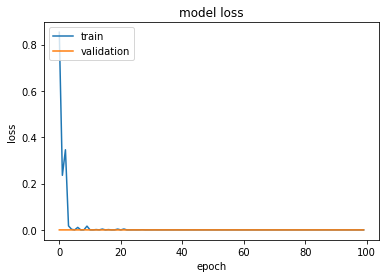

In [49]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [50]:
model.evaluate(X_test, y_test, batch_size=50)

61530/61530 [==============================] - 1s 14us/sample - loss: 5.4030e-07 - mean_squared_error: 5.4030e-07 - mean_absolute_error: 4.9506e-04


[5.403016277919323e-07, 5.403016e-07, 0.0004950624]

In [51]:
prediction = model.predict(X_test)

In [52]:
accuracy = 1 - sum(abs(scaler.inverse_transform(prediction) - scaler.inverse_transform(y_test))) / sum(scaler.inverse_transform(y_test))

print('Total accuracy = %.2f%%' % (accuracy * 100))

Total accuracy = 86.90%
